# Google OR-Tools で la40, ta80を解く

## 参考

- Google OR-Tools 公式 (`cp_model` について) : https://developers.google.com/optimization/reference/python/sat/python/cp_model#cp_model.CpModel


In [1]:
from time import time
import random
import collections

import numpy as np
import matplotlib.pyplot as plt
from ortools.sat.python import cp_model
from tqdm.notebook import tqdm

from la40.loader import read_benchmark_task_data
from utils.drawing_tool import create_colors


# データ読み込み

In [2]:
# 1つのジョブの全タスクの実行マシンIDと実行時間をまとめたもの
JobData = list[tuple[int, int]]
# tuple[int, int]: (machine_id, processing_time)

# ※ Job情報の見本
# jobs_data = [  # task = (machine_id, processing_time).
#     [(0, 3), (1, 2), (2, 2)],  # Job0
#     [(0, 2), (2, 1), (1, 4)],  # Job1
#     [(1, 4), (2, 3)],  # Job2
#     [(1, 2), (0, 1), (2, 4)],  # Job3
#     [(2, 1), (0, 2), (1, 1)],  # Job4
# ]


# la40
# processing_time_per_job, machine_sequence_per_job = read_benchmark_task_data(benchmark_data_path='data/jssp/la40.txt')
processing_time_per_job, machine_sequence_per_job = read_benchmark_task_data(benchmark_data_path='../data/jssp/ta80.txt')

# Job情報整形
# la40 から取得したデータを上記の形式に変換する
jobs_data: list[JobData] = []
for process_times_for_job, machine_seqs_for_job in zip(
    processing_time_per_job, machine_sequence_per_job
):
    job_data: JobData = [
        (int(machine_seq), int(process_time))
        for process_time, machine_seq in zip(
            process_times_for_job, machine_seqs_for_job
        )
    ]
    jobs_data.append(job_data)

# jobs_data

# ソルバーの初期化、決定変数・制約条件・目的関数の定義

In [3]:
# Machineの数
machines_count = 1 + max(task[0] for job in jobs_data for task in job)
all_machines = range(machines_count)

# 全 Job 内の全 Task の合計時間
horizon = sum(
    task[1]
    for job in jobs_data
    for task in job
)

# モデルの作成
model = cp_model.CpModel()

In [4]:
# Taskの種類
task_type = collections.namedtuple('task_type', 'start end interval')

# ジョブタスクの処理時間
all_tasks = {}
machine_to_intervals = collections.defaultdict(list)

# 開始、終了、処理時間変数を作成
for job_id, job in enumerate(jobs_data):
    for task_id, task in enumerate(job):
        machine = task[0]  # タスクを実行できるマシンの ID
        duration = task[1]  # タスク実行の所要時間
        suffix = '_%i_%i' % (job_id, task_id)
        start_var = model.NewIntVar(0, horizon, 'start' + suffix)  # NewIntVar(最小値, 最大値, 変数名)
        end_var = model.NewIntVar(0, horizon, 'end' + suffix)
        interval_var = model.NewIntervalVar(
            start_var, duration, end_var, 'interval' + suffix
        )
        all_tasks[job_id, task_id] = task_type(
            start=start_var, end=end_var, interval=interval_var
        )
        machine_to_intervals[machine].append(interval_var)


In [5]:
# -------------------------------------------------------
# Constraint
# -------------------------------------------------------
# 重複無の制約を追加
for machine in all_machines:
    # 各マシンにおいて行われるジョブの実行時間帯が重なってはならない
    model.AddNoOverlap(machine_to_intervals[machine])

# 実行順序の制約を追加
for job_id, job in enumerate(jobs_data):
    for task_id in range(len(job) - 1):
        # 各ジョブにおける1つ1つのタスクの順番が守られていなければならない
        model.Add(all_tasks[job_id, task_id + 1].start >= all_tasks[job_id, task_id].end)

# -------------------------------------------------------
# 目的関数
# -------------------------------------------------------
obj_var = model.NewIntVar(0, horizon, 'makespan')

# makespan: 全てのジョブの全てのタスクの終了時間の内、一番遅いもの
model.AddMaxEquality(obj_var, [
    all_tasks[job_id, len(job) - 1].end
    for job_id, job in enumerate(jobs_data)
])

# 最適化で、makespanをMinimize(最小に)することを目指す
model.Minimize(obj_var)


# 最適化実行

In [6]:
def optimize(solver, model, timeLimit):
    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = timeLimit

    start = time()
    status = solver.Solve(model)
    exec_time = time() - start

    # Statistics.
    print("\nStatistics")
    print(f"  - conflicts: {solver.NumConflicts()}")
    print(f"  - branches : {solver.NumBranches()}")
    print(f"  - wall time: {solver.WallTime()}s")

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        print(f'Optimal Schedule Length: {solver.ObjectiveValue()}')
    else:
        print('No solution found.')

    return exec_time, solver.ObjectiveValue()


timeLimit = 600  # seconds
exec_time_hist: list = []
makespan_hist: list[int] = []

for i in tqdm(range(0, 10), desc="Optimization"):
    seed: int = i
    random.seed(seed)
    np.random.seed(seed)

    solver = cp_model.CpSolver()
    exec_time, makespan = optimize(solver, model, timeLimit)

    exec_time_hist.append(exec_time)
    makespan_hist.append(makespan)

exec_time_hist, makespan_hist

Optimization:   0%|          | 0/10 [00:00<?, ?it/s]


Statistics
  - conflicts: 14381
  - branches : 139565
  - wall time: 600.280045284s
Optimal Schedule Length: 5443.0

Statistics
  - conflicts: 14211
  - branches : 132564
  - wall time: 600.309235006s
Optimal Schedule Length: 5409.0

Statistics
  - conflicts: 13462
  - branches : 119786
  - wall time: 600.091035989s
Optimal Schedule Length: 5427.0

Statistics
  - conflicts: 15815
  - branches : 129576
  - wall time: 600.099856185s
Optimal Schedule Length: 5449.0

Statistics
  - conflicts: 15074
  - branches : 115870
  - wall time: 600.212662323s
Optimal Schedule Length: 5441.0

Statistics
  - conflicts: 14996
  - branches : 137130
  - wall time: 600.105015864s
Optimal Schedule Length: 5464.0

Statistics
  - conflicts: 14765
  - branches : 114057
  - wall time: 600.137791472s
Optimal Schedule Length: 5435.0

Statistics
  - conflicts: 12045
  - branches : 119637
  - wall time: 600.1049273780001s
Optimal Schedule Length: 5495.0

Statistics
  - conflicts: 13549
  - branches : 124209
  - w

([600.2907619476318,
  600.3181638717651,
  600.098646402359,
  600.1088953018188,
  600.2264890670776,
  600.115965127945,
  600.1498382091522,
  600.1146800518036,
  600.1734337806702,
  600.1453094482422],
 [5443.0,
  5409.0,
  5427.0,
  5449.0,
  5441.0,
  5464.0,
  5435.0,
  5495.0,
  5445.0,
  5436.0])

In [7]:
np.mean(makespan_hist)

5444.4

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [10]:
np.sqrt(np.var(makespan_hist)), np.std(makespan_hist)

(21.666564102321345, 21.666564102321345)

# 可視化のため、1回のみ実行


In [14]:
def optimize(solver, model, timeLimit):
    # solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = timeLimit

    start = time()
    status = solver.Solve(model)
    exec_time = time() - start

    # Statistics.
    print("\nStatistics")
    print(f"  - conflicts: {solver.NumConflicts()}")
    print(f"  - branches : {solver.NumBranches()}")
    print(f"  - wall time: {solver.WallTime()}s")

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        print(f'Optimal Schedule Length: {solver.ObjectiveValue()}')
    else:
        print('No solution found.')

    return exec_time, solver.ObjectiveValue()


timeLimit = 600  # seconds
exec_time_hist: list = []
makespan_hist: list[int] = []

for i in tqdm(range(0, 1), desc="Optimization"):
    seed: int = i
    random.seed(seed)
    np.random.seed(seed)

    solver = cp_model.CpSolver()
    exec_time, makespan = optimize(solver, model, timeLimit)

    exec_time_hist.append(exec_time)
    makespan_hist.append(makespan)

exec_time_hist, makespan_hist

Optimization:   0%|          | 0/1 [00:00<?, ?it/s]


Statistics
  - conflicts: 15334
  - branches : 126495
  - wall time: 600.180363121s
Optimal Schedule Length: 5433.0


([600.191534280777], [5433.0])

# 実行結果の整理

In [16]:
# 解取り回し用
assigned_task_type = collections.namedtuple(
    'assigned_task_type', 'start job machine_id task_id duration'
)

# Job毎に割当てられたTaskのリストを作成
assigned_jobs = collections.defaultdict(list)  # 見つかった解を格納する
for job_id, job in enumerate(jobs_data):
    for task_id, task in enumerate(job):
        machine_id = task[0]
        start = solver.Value(all_tasks[job_id, task_id].start)
        assigned_job = assigned_task_type(
            start=start,
            job=job_id,
            machine_id=machine_id,
            task_id=task_id,
            duration=task[1]
        )
        assigned_jobs[job_id].append(assigned_job)
    assigned_jobs[job_id] = sorted(assigned_jobs[job_id])

# assigned_jobs

# 結果の可視化

100


  0%|          | 0/100 [00:00<?, ?it/s]

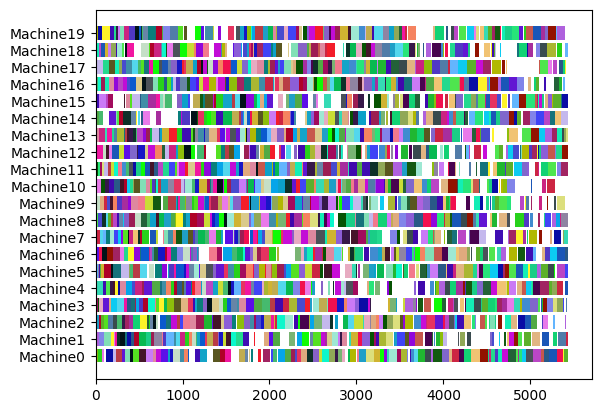

In [29]:
fig, ax = plt.subplots()

jobTaskIds: list[int] = list(range(len(jobs_data)))
machineIds: list[int] = list(range(len(jobs_data[0])))

# 縦軸の値
machine_name = [
    f"Machine{k}"
    for k in machineIds
]

# 横軸の値
start_time = [0] * len(machineIds)
process_time = [0] * len(machineIds)

colors: list[str] = create_colors(len(jobTaskIds))
print(len(colors))
for jobId, assigned_tasks in tqdm(assigned_jobs.items(), total=len(assigned_jobs.keys())):
    color = colors[:len(jobTaskIds)][jobId]
    for task in assigned_tasks:
        start_time[task.machine_id - 1] = task.start
        process_time[task.machine_id - 1] = task.duration

        # 1回だけ legend 登録用の label を渡す
        if task.task_id == 0:
            ax.barh(machine_name, process_time, left = start_time, color=color, label=f"job: {jobId}")
        else:
            ax.barh(machine_name, process_time, left = start_time, color=color)
        start_time[task.machine_id - 1] = 0
        process_time[task.machine_id - 1] = 0

# plt.legend()
